In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, roc_auc_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tensorflow.keras import datasets, utils
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier
np.random.seed(0)
from tqdm.notebook import tqdm

import os


In [2]:
# 전처리 진행

train= pd.read_csv('open/train4.csv')

#train4.csv 결측치행, index 열 제거
train.dropna(inplace=True)
train.drop(['Unnamed: 0'], axis=1, inplace=True)


# 성별 분류
train['gender'] = train['gender'].replace(['F','M'],[0,1])

# 차량 소유 분류
train['car'] = train['car'].replace(['N','Y'],[0,1])

# 부동산(주택) 소유 분류
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
train['family_type'] = train['family_type'].replace(['Married','Civil marriage','Single / not married','Separated','Widow'],[1,1,0,0,0])

train.loc[train['family_size'] >= 5,'family_size']=5
train.loc[train['child_num'] >= 1,'child_num']=1

train['age'] = train['DAYS_BIRTH']*(-1)/365
train['age'] = train['age'].round(0)

# train['begin_month'] = train['begin_month']* -1
# train.loc[train['DAYS_EMPLOYED'] >0,'DAYS_EMPLOYED']=0
# train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED']* -1
train.drop('DAYS_BIRTH',axis=1,inplace=True)

train['age']= -train['age']
# test['age']= -test['age']
train['income_total'] = train['income_total']/10000 

label_encoder=LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
train['edu_type']=label_encoder.fit_transform(train['edu_type'])
train['family_type']=label_encoder.fit_transform(train['family_type'])
train['house_type']=label_encoder.fit_transform(train['house_type'])
train['income_total']=label_encoder.fit_transform(train['income_total'])
train['occyp_type']=label_encoder.fit_transform(train['occyp_type'])

In [3]:
train_y = train[['credit']].copy()
train_x = train.drop('credit',axis=1).copy()

In [4]:
train_x

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,age
0,0,0,0,0,145,0,1,1,2,4709,0,0,0,0,2.0,6.0,38.0
1,0,0,1,1,165,0,4,1,1,1540,0,0,1,8,3.0,5.0,31.0
2,1,1,1,0,214,4,1,1,1,4434,0,1,0,10,2.0,22.0,52.0
3,0,0,1,0,145,0,4,1,1,2092,0,1,0,14,2.0,37.0,41.0
4,0,1,1,0,111,2,1,1,1,2105,0,0,0,10,2.0,26.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24818,0,0,0,1,156,2,4,1,1,1984,0,0,0,3,4.0,2.0,33.0
24819,0,0,1,1,133,4,1,0,1,2475,0,0,0,5,2.0,47.0,42.0
24820,0,1,0,0,181,4,4,1,5,2015,0,0,0,3,2.0,25.0,28.0
24821,1,0,1,0,121,4,2,0,1,107,0,0,0,8,1.0,59.0,28.0


In [5]:
# train-Valid set split
np.random.seed(42)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.7, .3], size=(train.shape[0],))

train_indices = train_x[train.Set=="train"].index
valid_indices = train_x[train.Set=="valid"].index

In [6]:
# Encoding

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in tqdm(train_x.columns):
    if types[col] == 'object' or nunique[col] < 200: # 컬럼의 unique 값이 200개 이하면 Categorical 변수로 변환, 그 외에는 Numerical로 판단하여 Null value를 평균값으로 대체
        print(col, train_x[col].nunique())
        l_enc = LabelEncoder()
        train_x[col] = train_x[col].fillna("NaN")
        train_x[col] = l_enc.fit_transform(train_x[col].values)
#         try:
#             test_X[col] = test_x[col].fillna("NaN")
#             test_x[col] = l_enc.transform(test_x[col].values)
#         except:
#             print(f"Column {col} does not exist in test set")
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        training_mean = train_x.loc[train_indices, col].mean()
        train.fillna(training_mean, inplace=True)
#         test.fillna(training_mean, inplace=True)

  0%|          | 0/17 [00:00<?, ?it/s]

gender 2
car 2
reality 2
child_num 2
income_type 5
edu_type 5
family_type 2
house_type 6
work_phone 2
phone 2
email 2
occyp_type 18
family_size 5
begin_month 61
age 49


In [7]:
train_x

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,age
0,0,0,0,0,145,0,1,1,2,4709,0,0,0,0,1,6,17
1,0,0,1,1,165,0,4,1,1,1540,0,0,1,8,2,5,10
2,1,1,1,0,214,4,1,1,1,4434,0,1,0,10,1,22,31
3,0,0,1,0,145,0,4,1,1,2092,0,1,0,14,1,37,20
4,0,1,1,0,111,2,1,1,1,2105,0,0,0,10,1,26,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24818,0,0,0,1,156,2,4,1,1,1984,0,0,0,3,3,2,12
24819,0,0,1,1,133,4,1,0,1,2475,0,0,0,5,1,47,21
24820,0,1,0,0,181,4,4,1,5,2015,0,0,0,3,1,25,7
24821,1,0,1,0,121,4,2,0,1,107,0,0,0,8,0,59,7


In [8]:
# Define categorical features for categorical embeddings
unused_feat = ['Set']
features = [ col for col in train_x.columns] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# 입력으로 Categorical 변수를 Embedding 하기 때문에, Categorical 변수라는 것을 지정하기 위해 cat_idxs와 cat_dims를 저장

In [9]:
# Creating train/valid/test matrices

X_train = train_x[features].values[train_indices]
y_train = train_y.values[train_indices]

X_valid = train_x[features].values[valid_indices]
y_valid = train_y.values[valid_indices]

In [10]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(17368, 17)
(7455, 17)
(17368, 1)
(7455, 1)


# model fit

In [11]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                cat_idxs=cat_idxs,
                                cat_dims=cat_dims,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50,
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', 
                                lambda_sparse=0, 
                      )

In [12]:
max_epochs = 50
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=max_epochs,
    patience=50, # please be patient
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)

epoch 0  | loss: 1.02524 | train_accuracy: 0.63675 | valid_accuracy: 0.64467 |  0:00:17s
epoch 1  | loss: 0.87285 | train_accuracy: 0.65235 | valid_accuracy: 0.65915 |  0:00:35s
epoch 2  | loss: 0.85788 | train_accuracy: 0.66289 | valid_accuracy: 0.66707 |  0:00:53s
epoch 3  | loss: 0.84375 | train_accuracy: 0.67532 | valid_accuracy: 0.67874 |  0:01:10s
epoch 4  | loss: 0.82336 | train_accuracy: 0.68701 | valid_accuracy: 0.68759 |  0:01:28s
epoch 5  | loss: 0.81872 | train_accuracy: 0.68724 | valid_accuracy: 0.68773 |  0:01:45s
epoch 6  | loss: 0.81771 | train_accuracy: 0.68724 | valid_accuracy: 0.68773 |  0:02:03s
epoch 7  | loss: 0.81605 | train_accuracy: 0.68724 | valid_accuracy: 0.68773 |  0:02:20s
epoch 8  | loss: 0.81628 | train_accuracy: 0.68724 | valid_accuracy: 0.68773 |  0:02:37s
epoch 9  | loss: 0.81455 | train_accuracy: 0.68724 | valid_accuracy: 0.68773 |  0:02:55s
epoch 10 | loss: 0.81301 | train_accuracy: 0.68724 | valid_accuracy: 0.68773 |  0:03:12s
epoch 11 | loss: 0.81

In [13]:
preds = np.array(clf.predict(X_valid)).transpose().astype(float)
test_auc = accuracy_score(y_valid,preds)

In [14]:
test_auc

0.6883970489604292

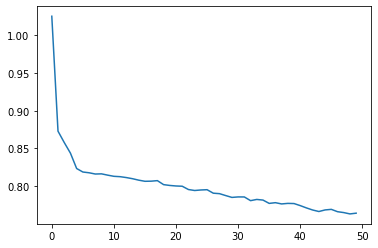

In [15]:
plt.plot(clf.history['loss'])
# plt.plot(clf.history['valid']['loss'][5:])

BEST ACCURACY SCORE ON VALIDATION SET : 0.6883970489604292


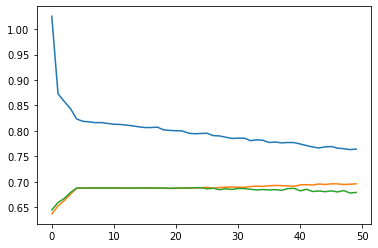

In [16]:
# plot losses
plt.plot(clf.history['loss'])

# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

# determine best accuracy for validation set
preds_valid = np.array(clf.predict(X_valid)).transpose().astype(float)
valid_acc = accuracy_score(preds_valid, y_valid)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")

In [ ]:
출처
https://www.kaggle.com/code/hamishdickson/tabnetmultitaskclassifier/notebook
https://towardsdatascience.com/tabnet-deep-neural-network-for-structured-tabular-data-39eb4b27a9e4

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6988cc49-778f-4dcf-a2dc-70fd016d5812' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>